In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from scipy.signal import medfilt, savgol_filter
from xgboost import XGBClassifier

from automated_scoring.config import cfg
from automated_scoring.io import load_dataset, save_dataset
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.dataset.sampling.permutation import permute_recipients
from automated_scoring.sliding_metrics import get_window_slices, SlidingWindowAggregator
from automated_scoring.classification import (
    predict,
    plot_confusion_matrix,
    plot_classification_timeline,
)
from automated_scoring.utils import ensure_generator

from helpers import subsample_train

cfg.key_keypoints = "pose"
cfg.key_timestamp = "time_stamp"

cfg.trajectory_keys = (
    "pose",
    "time_stamp",
)

In [3]:
dataset_full = load_dataset("cichlids", directory="datasets/social_cichlids", target="dyads")

Loading categories (approach, chase, dart_bite, frontal_display, lateral_display, none, quiver) from observations file, specify categories argument if incomplete.


In [4]:
random_state = ensure_generator(1)

In [5]:
d = np.arange(20, dtype=float).reshape(2, 10).T

In [6]:
d[5, 0] = np.nan

In [7]:
from sklearn.impute import KNNImputer

In [8]:
dataset_train, dataset_test = dataset_full.split(0.8, random_state=random_state)

In [9]:
observations = dataset_train.get_observations()
observations = observations[observations["category"] != "none"]
time_scales, slices = get_window_slices(3, time_scales=(91, ), durations=observations["duration"])

Time scales adjusted to match num_windows_per_scale: (91,) -> [93].


In [10]:
from automated_scoring.sliding_metrics import metrics

extractor = DataFrameFeatureExtractor(
    cache_directory="/media/paul/t5_3/cache",
    pipeline=Pipeline(
        [
            ("impute", KNNImputer()),
            ("aggregate", SlidingWindowAggregator([metrics.median, metrics.q10, metrics.q90], max(time_scales), slices)),
        ]
    ),
    refit_pipeline=True,
).read_yaml("config_file-cichlids.yaml")

In [11]:
dyad = dataset_train.select("GH030423").select(('0', '1'))

In [16]:
features = dyad.sample(extractor)[0]

In [9]:
from automated_scoring.sliding_metrics.sliding_metrics import apply_multiple_to_sliding_windows
from automated_scoring.sliding_metrics import metrics

from automated_scoring.features import target_vectors, velocity, as_dataframe, target_velocity

from automated_scoring.utils import perform_operation
from automated_scoring import math

In [17]:
features

,speed_t(5)-0-median(-46:-15),speed_t(5)-0-q10(-46:-15),speed_t(5)-0-q90(-46:-15),speed_t(5)-0-median(-15:16),speed_t(5)-0-q10(-15:16),speed_t(5)-0-q90(-15:16),speed_t(5)-0-median(16:47),speed_t(5)-0-q10(16:47),speed_t(5)-0-q90(16:47),speed_t(5)-1-median(-46:-15),...,posture_alignment-2_1-1_0-q90(16:47),posture_alignment-2_1-2_1-median(-46:-15),posture_alignment-2_1-2_1-q10(-46:-15),posture_alignment-2_1-2_1-q90(-46:-15),posture_alignment-2_1-2_1-median(-15:16),posture_alignment-2_1-2_1-q10(-15:16),posture_alignment-2_1-2_1-q90(-15:16),posture_alignment-2_1-2_1-median(16:47),posture_alignment-2_1-2_1-q10(16:47),posture_alignment-2_1-2_1-q90(16:47)
0,0.498665,4.264689,0.406976,0.209607,2.737206,0.174148,0.923922,5.370252,3.428665,1.673269,...,0.884627,0.093443,0.202305,0.859157,0.047396,0.051673,0.814395,0.196078,0.589224,0.882917
1,0.498665,4.264689,0.406976,0.209607,2.737206,0.174148,0.923922,5.370252,3.428665,1.673269,...,0.884627,0.093443,0.202305,0.859157,0.047396,0.051673,0.814395,0.196078,0.589224,0.882917
2,0.498665,4.264689,0.406976,0.209607,2.737206,0.174148,0.923922,5.370252,3.428665,1.673269,...,0.884627,0.093443,0.202305,0.859157,0.047396,0.051673,0.814395,0.196078,0.589224,0.882917
3,0.498665,4.264689,0.406976,0.209607,2.737206,0.174148,0.923922,5.370252,3.428665,1.673269,...,0.884627,0.093443,0.202305,0.859157,0.047396,0.051673,0.814395,0.196078,0.589224,0.882917
4,0.498665,4.264689,0.406976,0.209607,2.737206,0.174148,0.923922,5.370252,3.428665,1.673269,...,0.884627,0.093443,0.202305,0.859157,0.047396,0.051673,0.814395,0.196078,0.589224,0.882917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,5.044837,1.790934,0.433642,2.775810,0.191555,0.136426,6.112511,6.652934,5.346476,4.530364,...,0.769041,0.568865,0.619856,0.742990,0.548420,0.598441,0.725772,0.605070,0.733153,0.769428
7169,5.044837,1.790934,0.433642,2.775810,0.191555,0.136426,6.112511,6.652934,5.346476,4.530364,...,0.769041,0.568865,0.619856,0.742990,0.548420,0.598441,0.725772,0.605070,0.733153,0.769428
7170,5.044837,1.790934,0.433642,2.775810,0.191555,0.136426,6.112511,6.652934,5.346476,4.530364,...,0.769041,0.568865,0.619856,0.742990,0.548420,0.598441,0.725772,0.605070,0.733153,0.769428
7171,5.044837,1.790934,0.433642,2.775810,0.191555,0.136426,6.112511,6.652934,5.346476,4.530364,...,0.769041,0.568865,0.619856,0.742990,0.548420,0.598441,0.725772,0.605070,0.733153,0.769428


In [58]:
result = apply_multiple_to_sliding_windows(
    features,
    31,
    [metrics.median, metrics.q10, metrics.q90],
    [slice(None, 11), slice(11, 21), slice(21, None)],
)

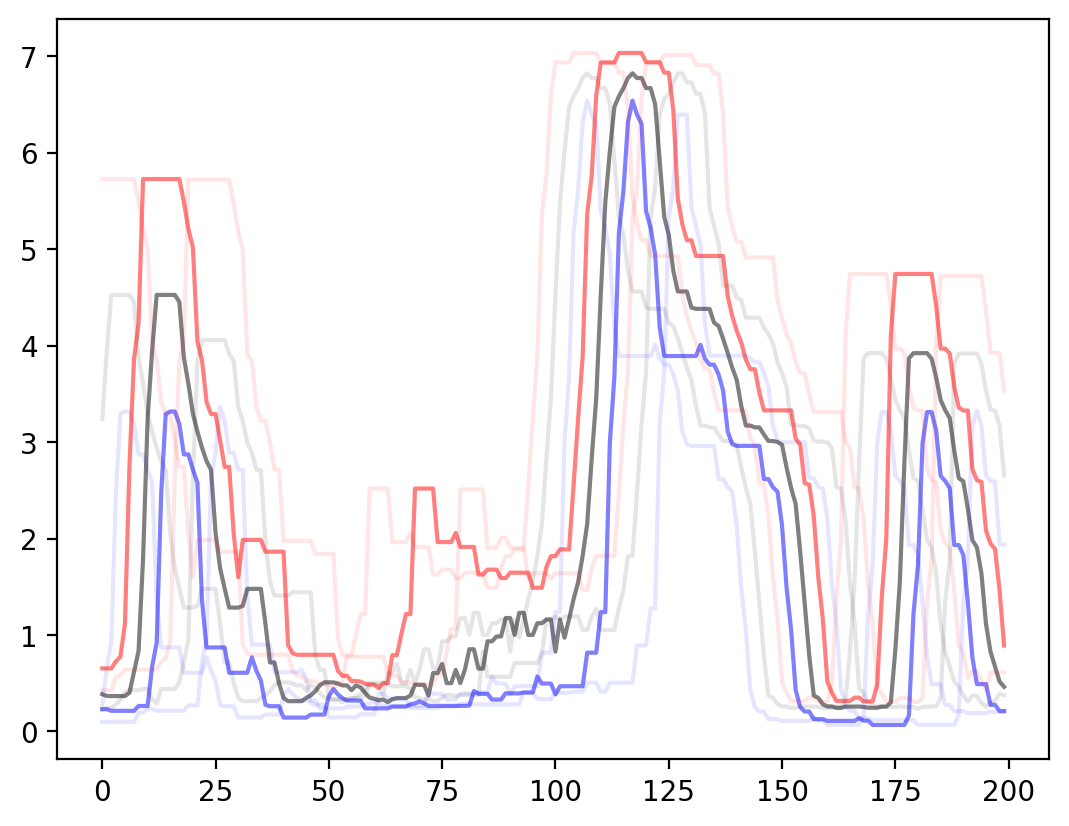

In [59]:
plt.plot(result[100:300, 0, 0, 0], c="k", alpha=0.1)
plt.plot(result[100:300, 0, 0, 1], c="k", alpha=0.5)
plt.plot(result[100:300, 0, 0, 2], c="k", alpha=0.1)

plt.plot(result[100:300, 0, 1, 0], c="b", alpha=0.1)
plt.plot(result[100:300, 0, 1, 1], c="b", alpha=0.5)
plt.plot(result[100:300, 0, 1, 2], c="b", alpha=0.1)

plt.plot(result[100:300, 0, 2, 0], c="r", alpha=0.1)
plt.plot(result[100:300, 0, 2, 1], c="r", alpha=0.5)
plt.plot(result[100:300, 0, 2, 2], c="r", alpha=0.1)

In [60]:
result.shape

(7173, 137, 3, 3)

In [61]:
result = result.reshape(result.shape[0], -1)

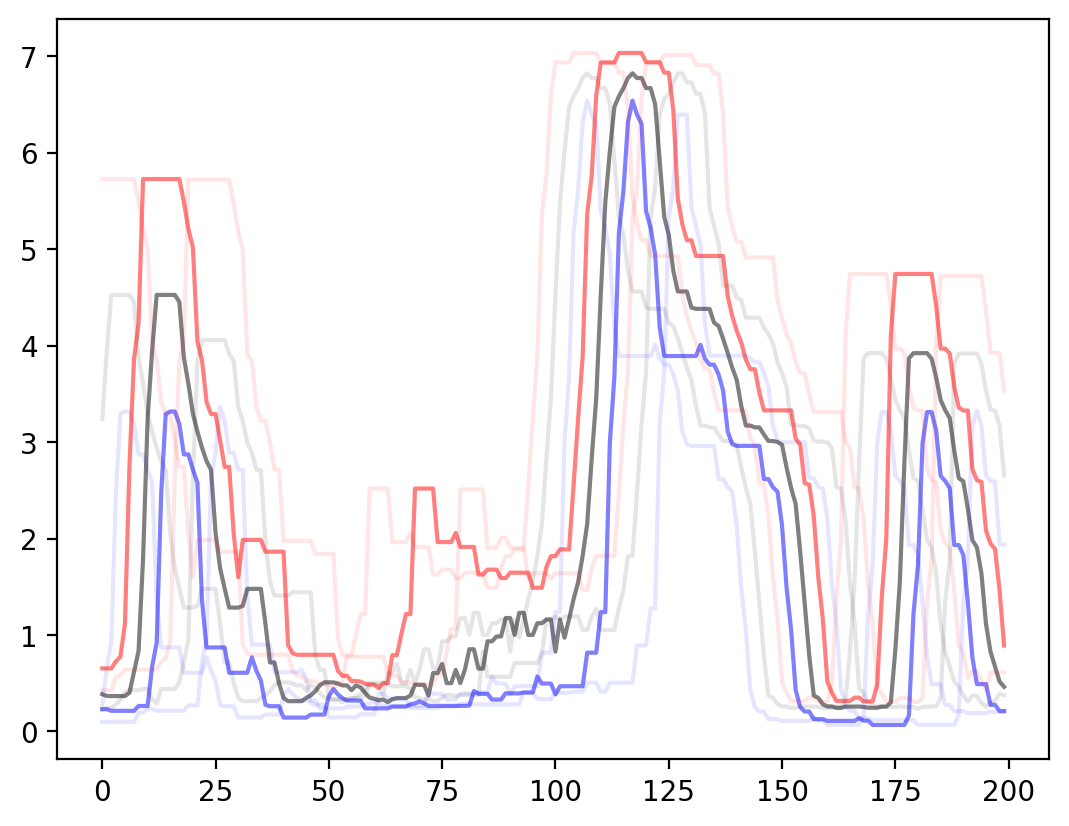

In [62]:
plt.plot(result[100:300, 0], c="k", alpha=0.1)
plt.plot(result[100:300, 1], c="k", alpha=0.5)
plt.plot(result[100:300, 2], c="k", alpha=0.1)

plt.plot(result[100:300, 3], c="b", alpha=0.1)
plt.plot(result[100:300, 4], c="b", alpha=0.5)
plt.plot(result[100:300, 5], c="b", alpha=0.1)

plt.plot(result[100:300, 6], c="r", alpha=0.1)
plt.plot(result[100:300, 7], c="r", alpha=0.5)
plt.plot(result[100:300, 8], c="r", alpha=0.1)

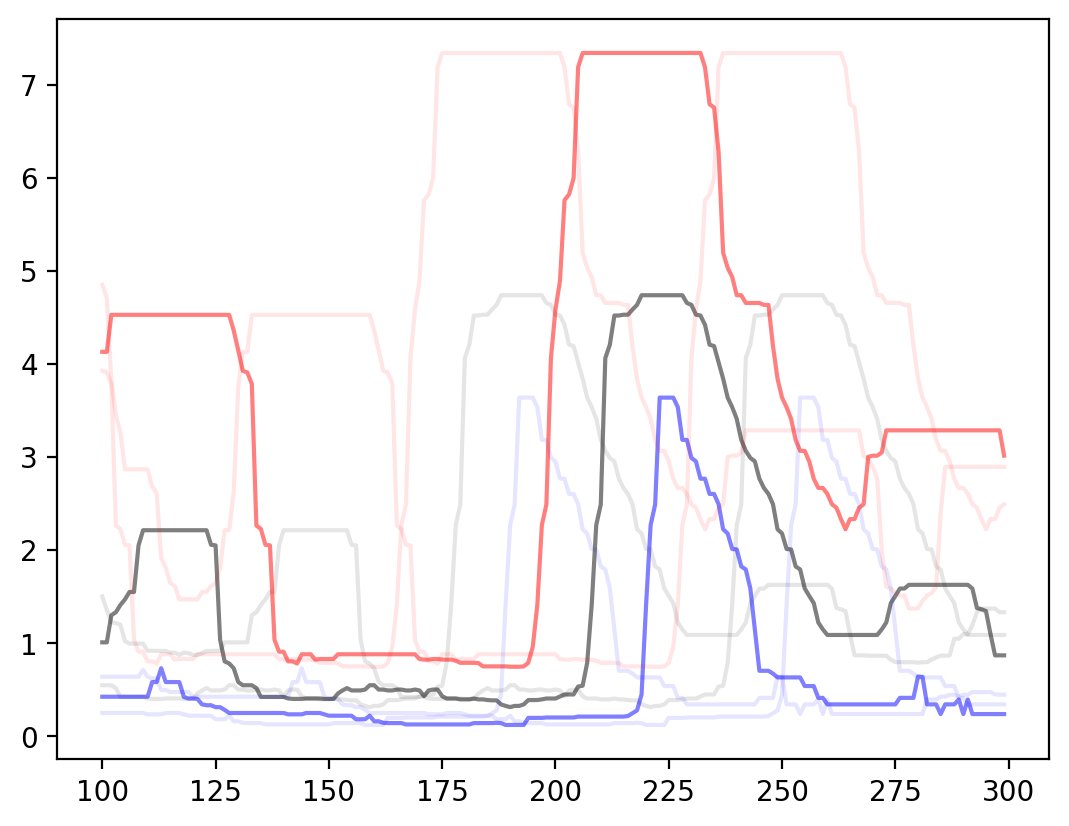

In [12]:
plt.plot(features.iloc[100:300, 9 + 0], c="k", alpha=0.1)
plt.plot(features.iloc[100:300, 9 + 1], c="k", alpha=0.5)
plt.plot(features.iloc[100:300, 9 + 2], c="k", alpha=0.1)

plt.plot(features.iloc[100:300, 9 + 3], c="b", alpha=0.1)
plt.plot(features.iloc[100:300, 9 + 4], c="b", alpha=0.5)
plt.plot(features.iloc[100:300, 9 + 5], c="b", alpha=0.1)

plt.plot(features.iloc[100:300, 9 + 6], c="r", alpha=0.1)
plt.plot(features.iloc[100:300, 9 + 7], c="r", alpha=0.5)
plt.plot(features.iloc[100:300, 9 + 8], c="r", alpha=0.1)

In [46]:
# %timeit SlidingWindowAggregator([metrics.mean, metrics.q10, metrics.q90], max(time_scales), slices).fit_transform(features)

6.97 s ± 63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [344]:
# features_np = np.asarray(features)
# features_np.shape

(7173, 161)

In [345]:
# features_sliding_window_view = np.lib.stride_tricks.sliding_window_view(
#     features_np,
#     max(time_scales),
#     axis=0,
# )

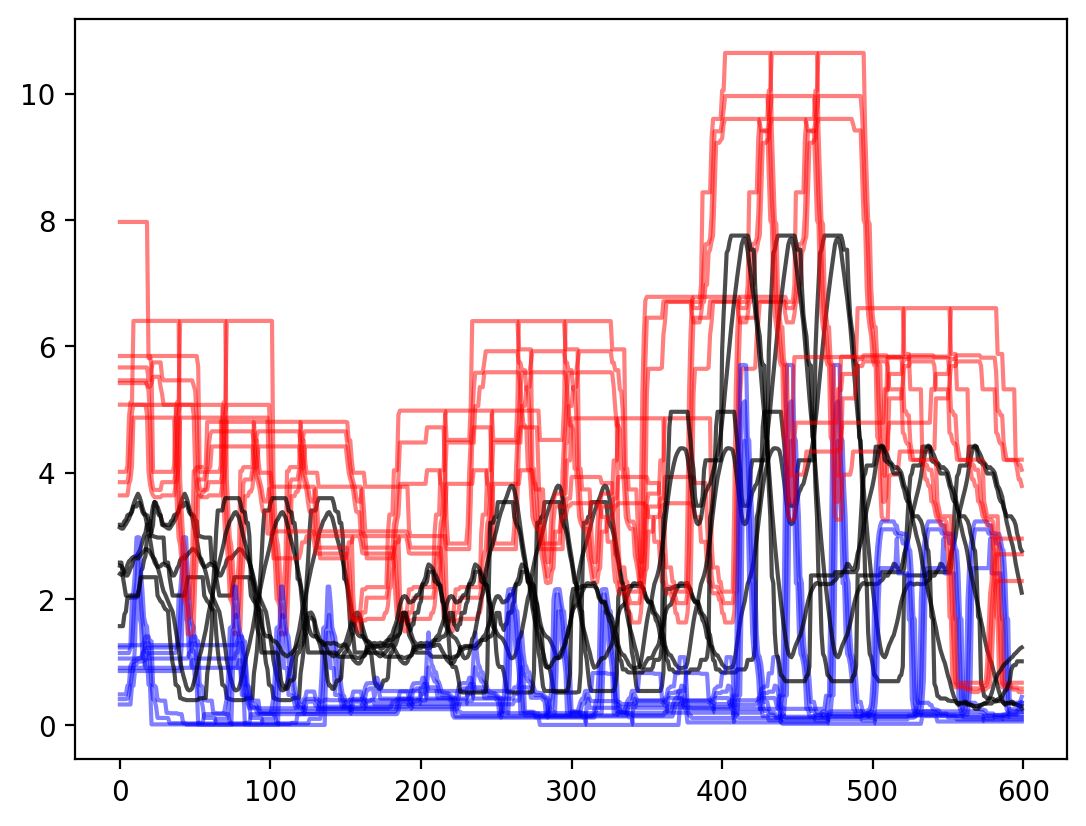

In [349]:
# # plt.plot(features_np[:800, 0], c="k", alpha=0.5)

# for s in slices:

#     plt.plot(pad(nb_max(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="r", alpha=0.5)
#     plt.plot(pad(nb_q90(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="r", alpha=0.5)
#     plt.plot(pad(nb_q95(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="r", alpha=0.5)
#     plt.plot(pad(nb_median(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="k", alpha=0.7)
#     plt.plot(pad(nb_mean(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="k", alpha=0.7)
#     plt.plot(pad(nb_q10(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="b", alpha=0.5)
#     plt.plot(pad(nb_q05(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="b", alpha=0.5)
#     plt.plot(pad(nb_min(features_sliding_window_view[..., s]), max(time_scales))[400:1000, 0], c="b", alpha=0.5)

In [379]:
# def apply_sliding_metrics(metrics, features: pd.DataFrame, window_size, slices):
#     features_sliding_window_view = np.lib.stride_tricks.sliding_window_view(features, window_size, axis=0)
#     sliding_metrics = np.zeros((*features.shape, len(metrics), len(slices)), dtype=np.float64)
#     for metric_idx, metric in enumerate(metrics):
#         for slice_idx, s in enumerate(slices):
#             sliding_metrics[..., metric_idx, slice_idx] = pad(metric(features_sliding_window_view), window_size)
#     return sliding_metrics

In [380]:
# sliding_metrics = apply_sliding_metrics(
#     [
#         nb_max,
#         nb_q90,
#         nb_q95,
#         nb_median,
#         nb_mean,
#         nb_q10,
#         nb_q05,
#         nb_min,
#     ],
#     features,
#     max(time_scales),
#     slices,
# )

In [387]:
# pd.DataFrame(sliding_metrics.reshape(sliding_metrics.shape[0], -1)).to_pickle("test.pkl")

In [19]:
X_train_none, y_train_none = dataset_train.subsample(
    extractor,
    0.001,
    categories=('none', ),
    try_even_subsampling=False,
    random_state=random_state,
)

X_frontal, y_frontal = dataset_train.subsample(
    extractor,
    0.25,
    categories=('frontal_display', ),
    try_even_subsampling=False,
    random_state=random_state,
)

X_minorities, y_minorities = dataset_train.subsample(
    extractor,
    1.0,
    categories=(
        'approach',
        'chase',
        'dart_bite',
        'lateral_display',
        'quiver',
    ),
    try_even_subsampling=False,
    random_state=random_state,
)

sampling_frequency = {0: 0.1, 1: 0.1, 2: 0.05, 3: 0.05, 4: 0.05}
X_additional = pd.concat(
    [
        permute_recipients(dataset_train, neighbor_rank=neighbor_rank).subsample(
            extractor,
            sampling_frequency[neighbor_rank],
            categories=(
                    'approach',
                    'frontal_display',
                    'chase',
                    'dart_bite',
                    'lateral_display',
                    'quiver',
            ),
            try_even_subsampling=False,
            random_state=random_state,
        )[0]
        for neighbor_rank in range(5)
    ]
)
y_additional = np.repeat("none", len(X_additional))

sampling:   0%|          | 0/1486 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
X = pd.concat([X_train_none, X_frontal, X_minorities, X_additional])
y = np.concat([y_train_none, y_frontal, y_minorities, y_additional])

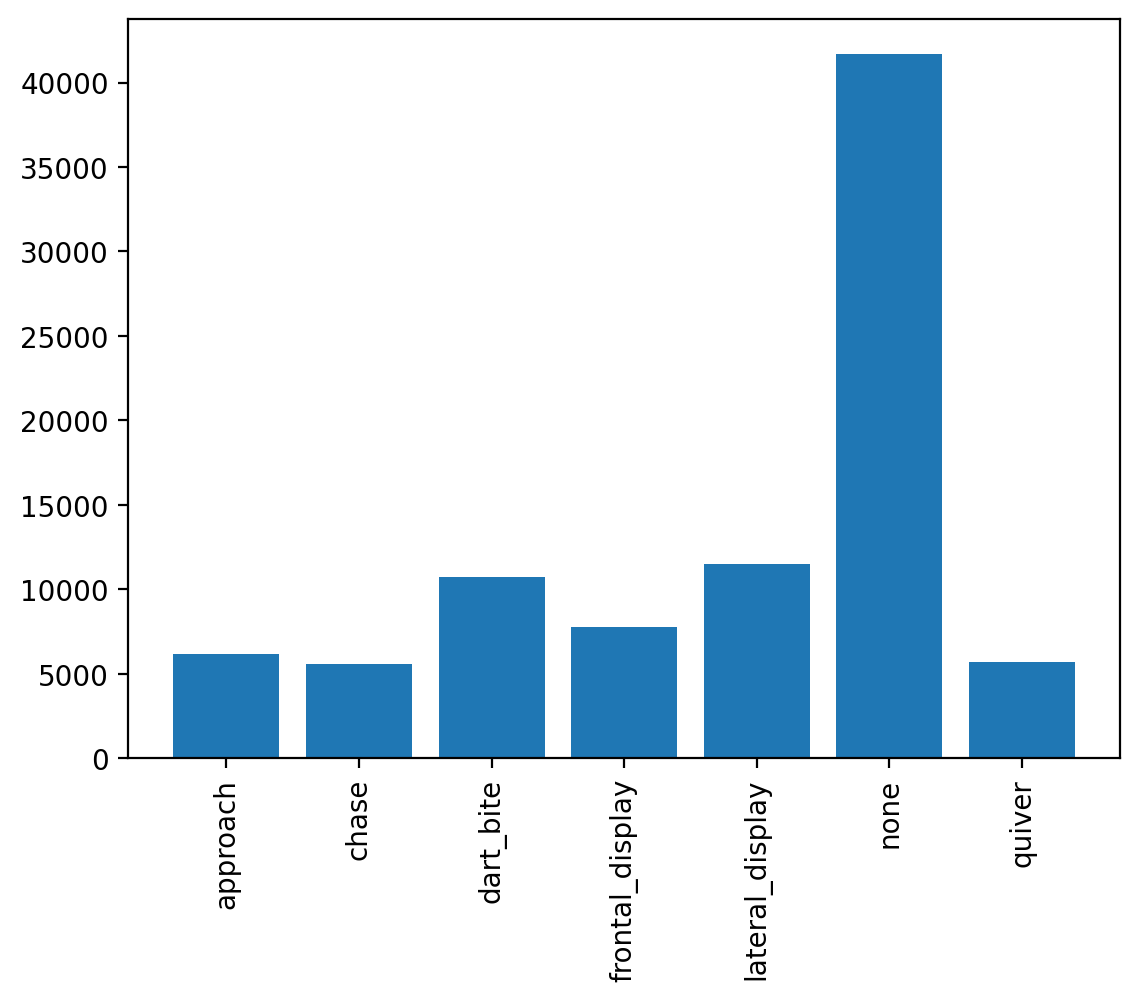

In [28]:
categories, counts = np.unique(y, return_counts=True)
ticks = np.arange(len(categories))
plt.bar(ticks, counts)
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(categories, rotation=90)
plt.show()

In [29]:
y = dataset_train.encode(y)

In [30]:
# specify and fit classification model
classifier = XGBClassifier(random_state=random_state).fit(
    X.to_numpy(), y, sample_weight=compute_sample_weight('balanced', y)
)
# use model for predictions on the test dataset
test_result = predict(dataset_test, classifier, extractor)

In [31]:
category_labels = ["appr", "chase", "dart", "front", "lat", "none", "quiv"]

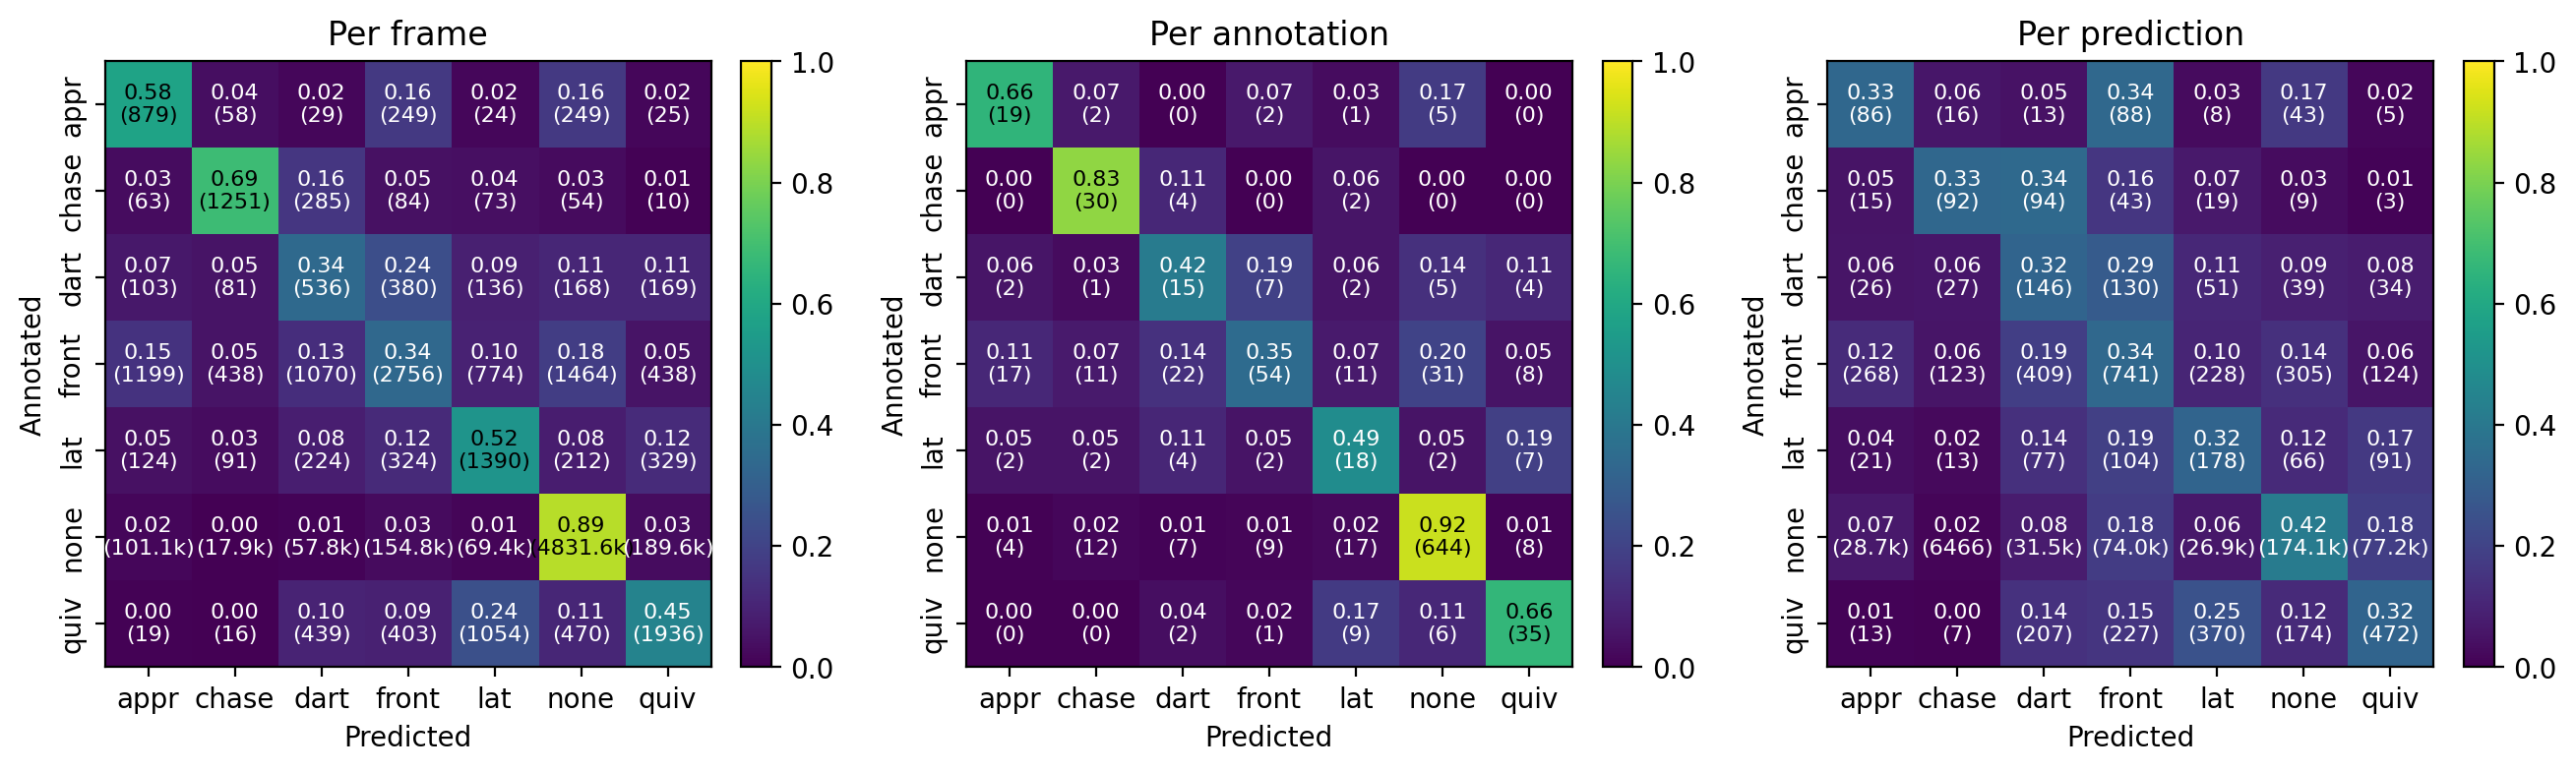

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_confusion_matrix(
    test_result.y_true_numeric,
    test_result.y_pred_numeric,
    ax=axes[0],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.annotations["category"].to_numpy()),
    dataset_train.encode(test_result.annotations["predicted_category"].to_numpy()),
    ax=axes[1],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(test_result.predictions["category"].to_numpy()),
    ax=axes[2],
    category_labels=category_labels,
)

axes[0].set_title("Per frame")
axes[1].set_title("Per annotation")
axes[2].set_title("Per prediction")

plt.show()

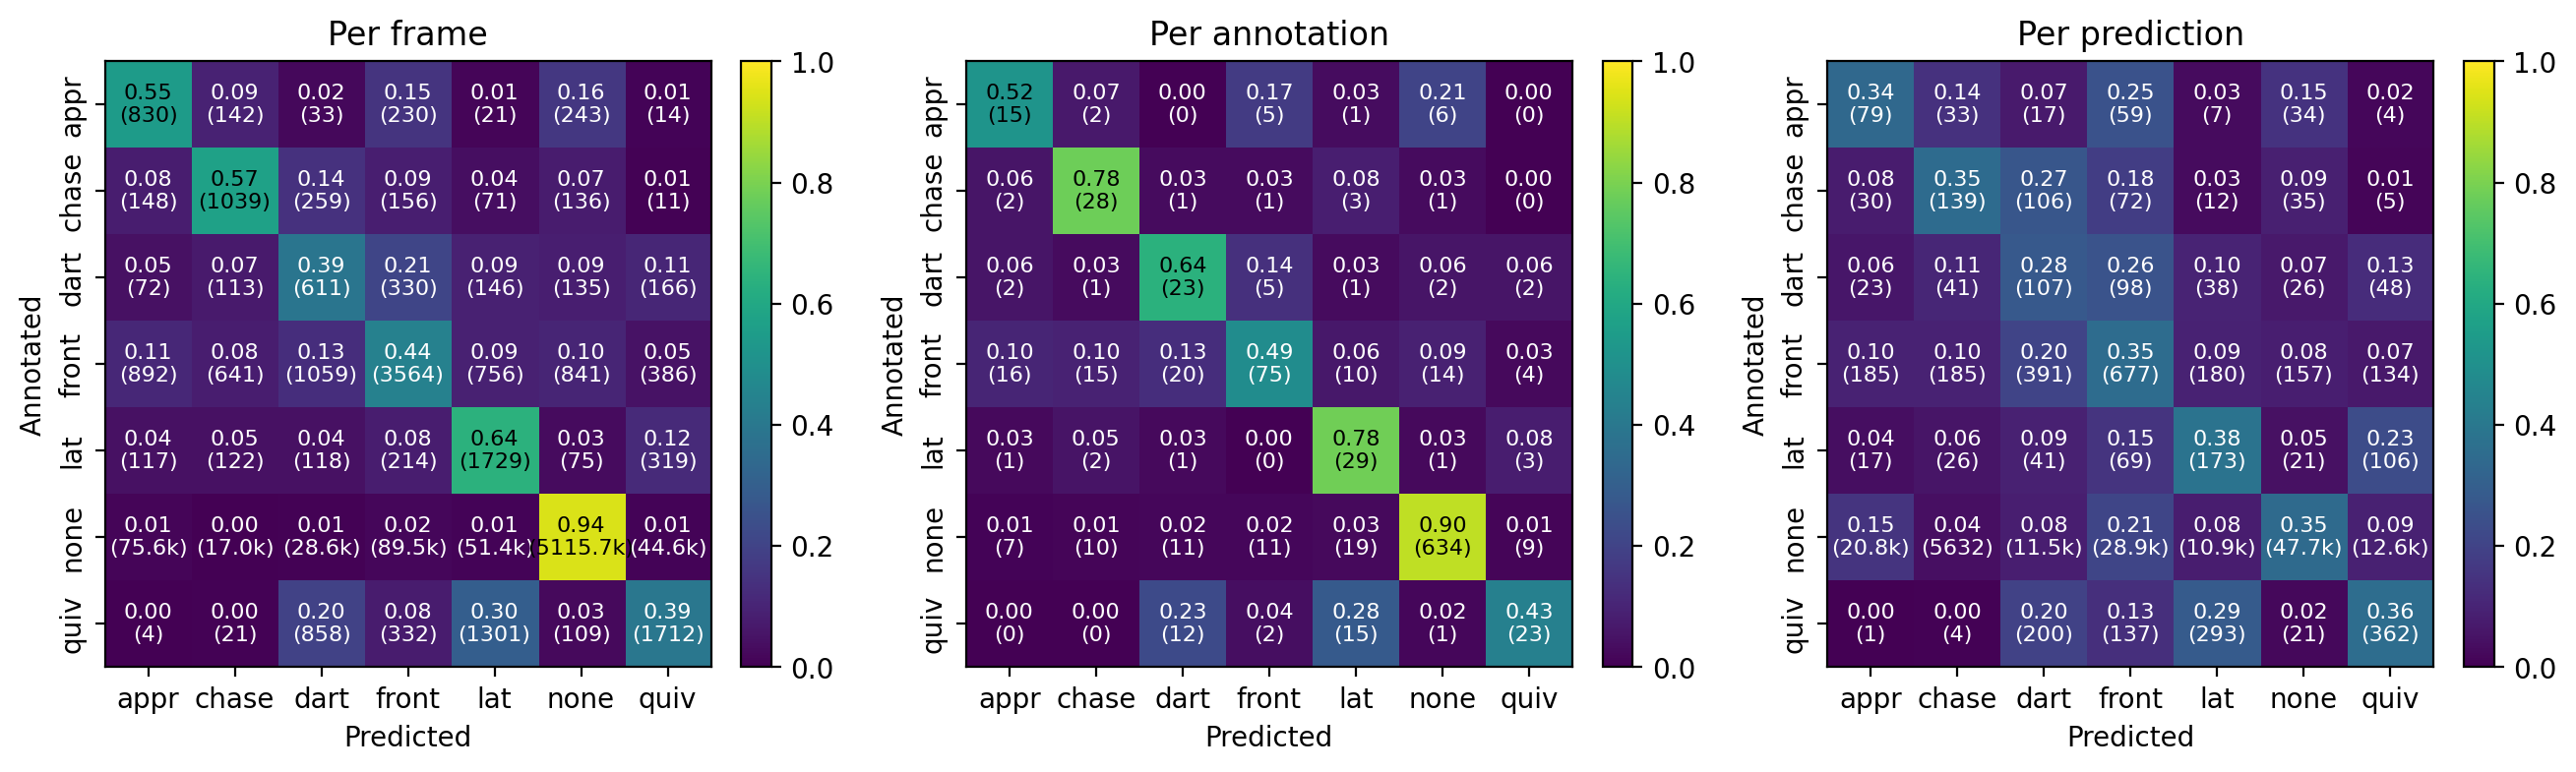

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_confusion_matrix(
    test_result.y_true_numeric,
    test_result.y_pred_numeric,
    ax=axes[0],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.annotations["category"].to_numpy()),
    dataset_train.encode(test_result.annotations["predicted_category"].to_numpy()),
    ax=axes[1],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(test_result.predictions["category"].to_numpy()),
    ax=axes[2],
    category_labels=category_labels,
)

axes[0].set_title("Per frame")
axes[1].set_title("Per annotation")
axes[2].set_title("Per prediction")

plt.show()

In [15]:
test_result = test_result.smooth([lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, 31, 1)])

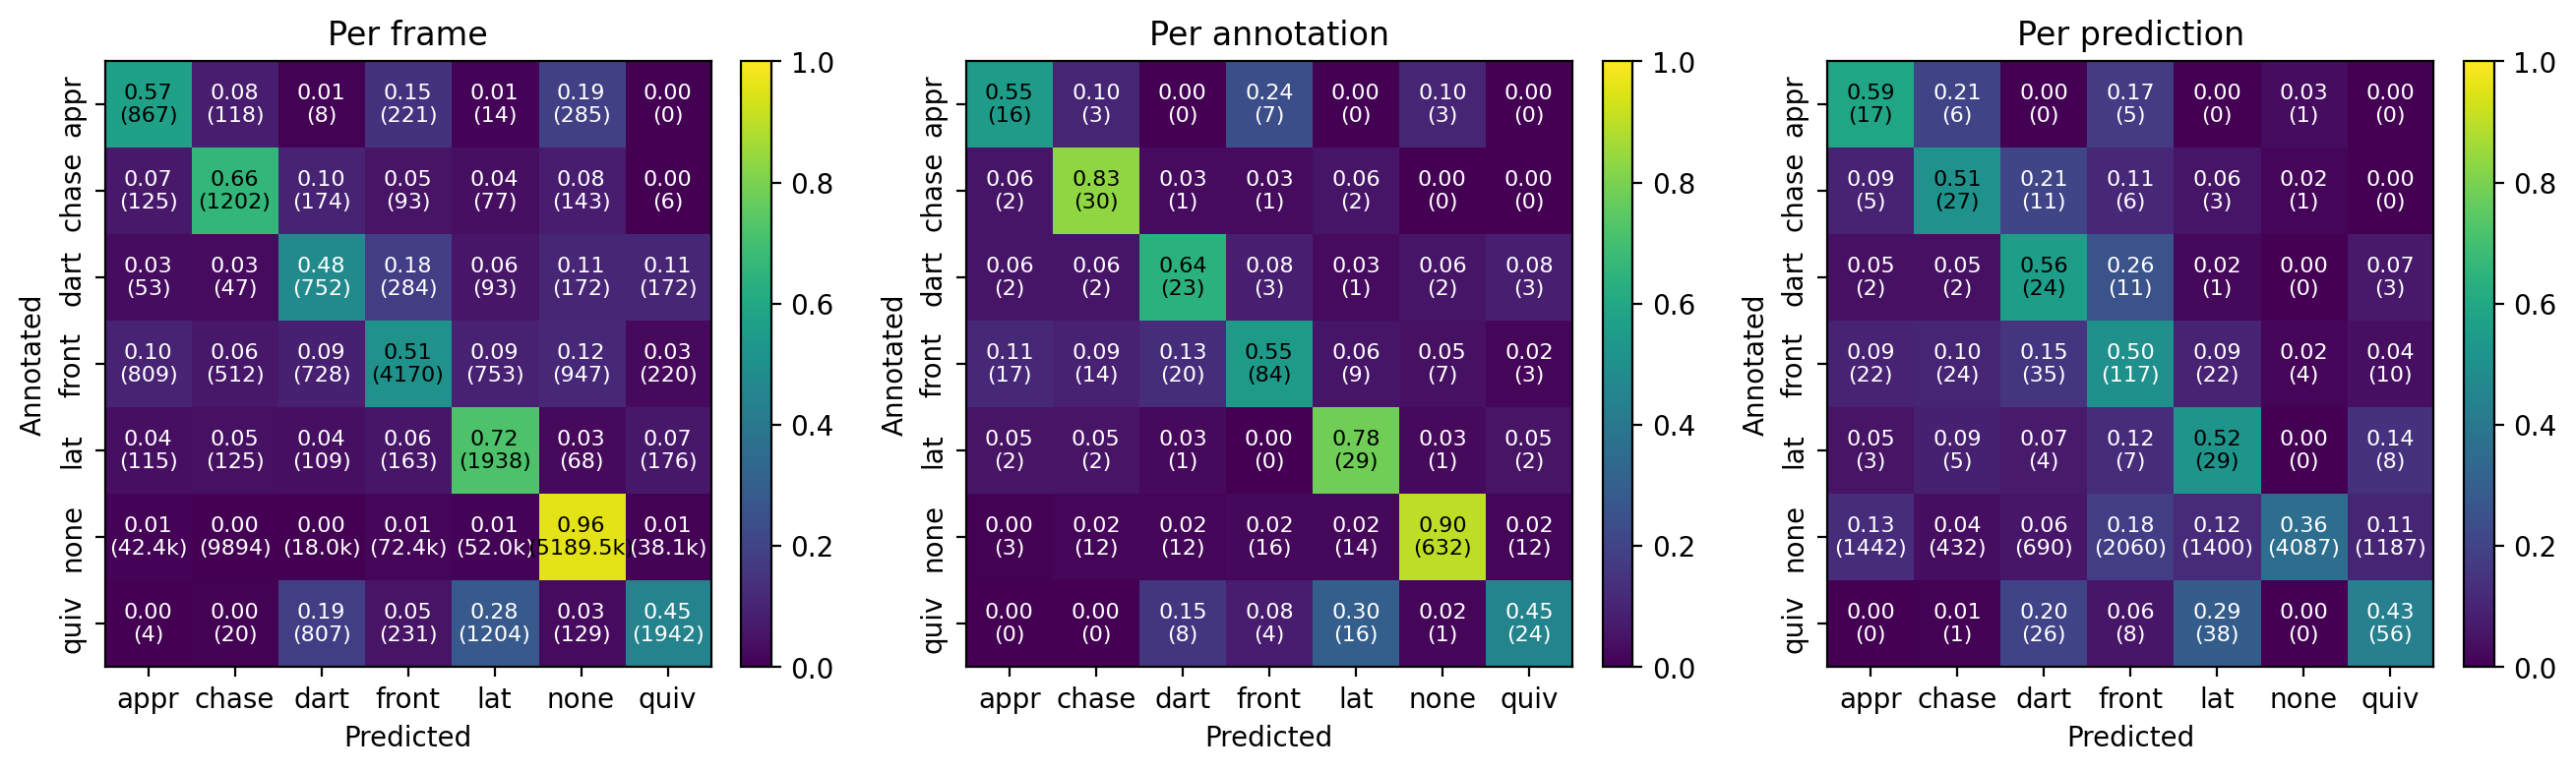

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_confusion_matrix(
    test_result.y_true_numeric,
    test_result.y_pred_numeric,
    ax=axes[0],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.annotations["category"].to_numpy()),
    dataset_train.encode(test_result.annotations["predicted_category"].to_numpy()),
    ax=axes[1],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(test_result.predictions["category"].to_numpy()),
    ax=axes[2],
    category_labels=category_labels,
)

axes[0].set_title("Per frame")
axes[1].set_title("Per annotation")
axes[2].set_title("Per prediction")

plt.show()

In [17]:
test_result = test_result.remove_overlapping_predictions(
    priority_func=lambda observations: ((1 - observations["max_probability"]) + (1 - observations["mean_probability"])) / 2,
    prefilter_recipient_bouts=True,
    max_bout_gap=60,
    max_allowed_bout_overlap=30,
)

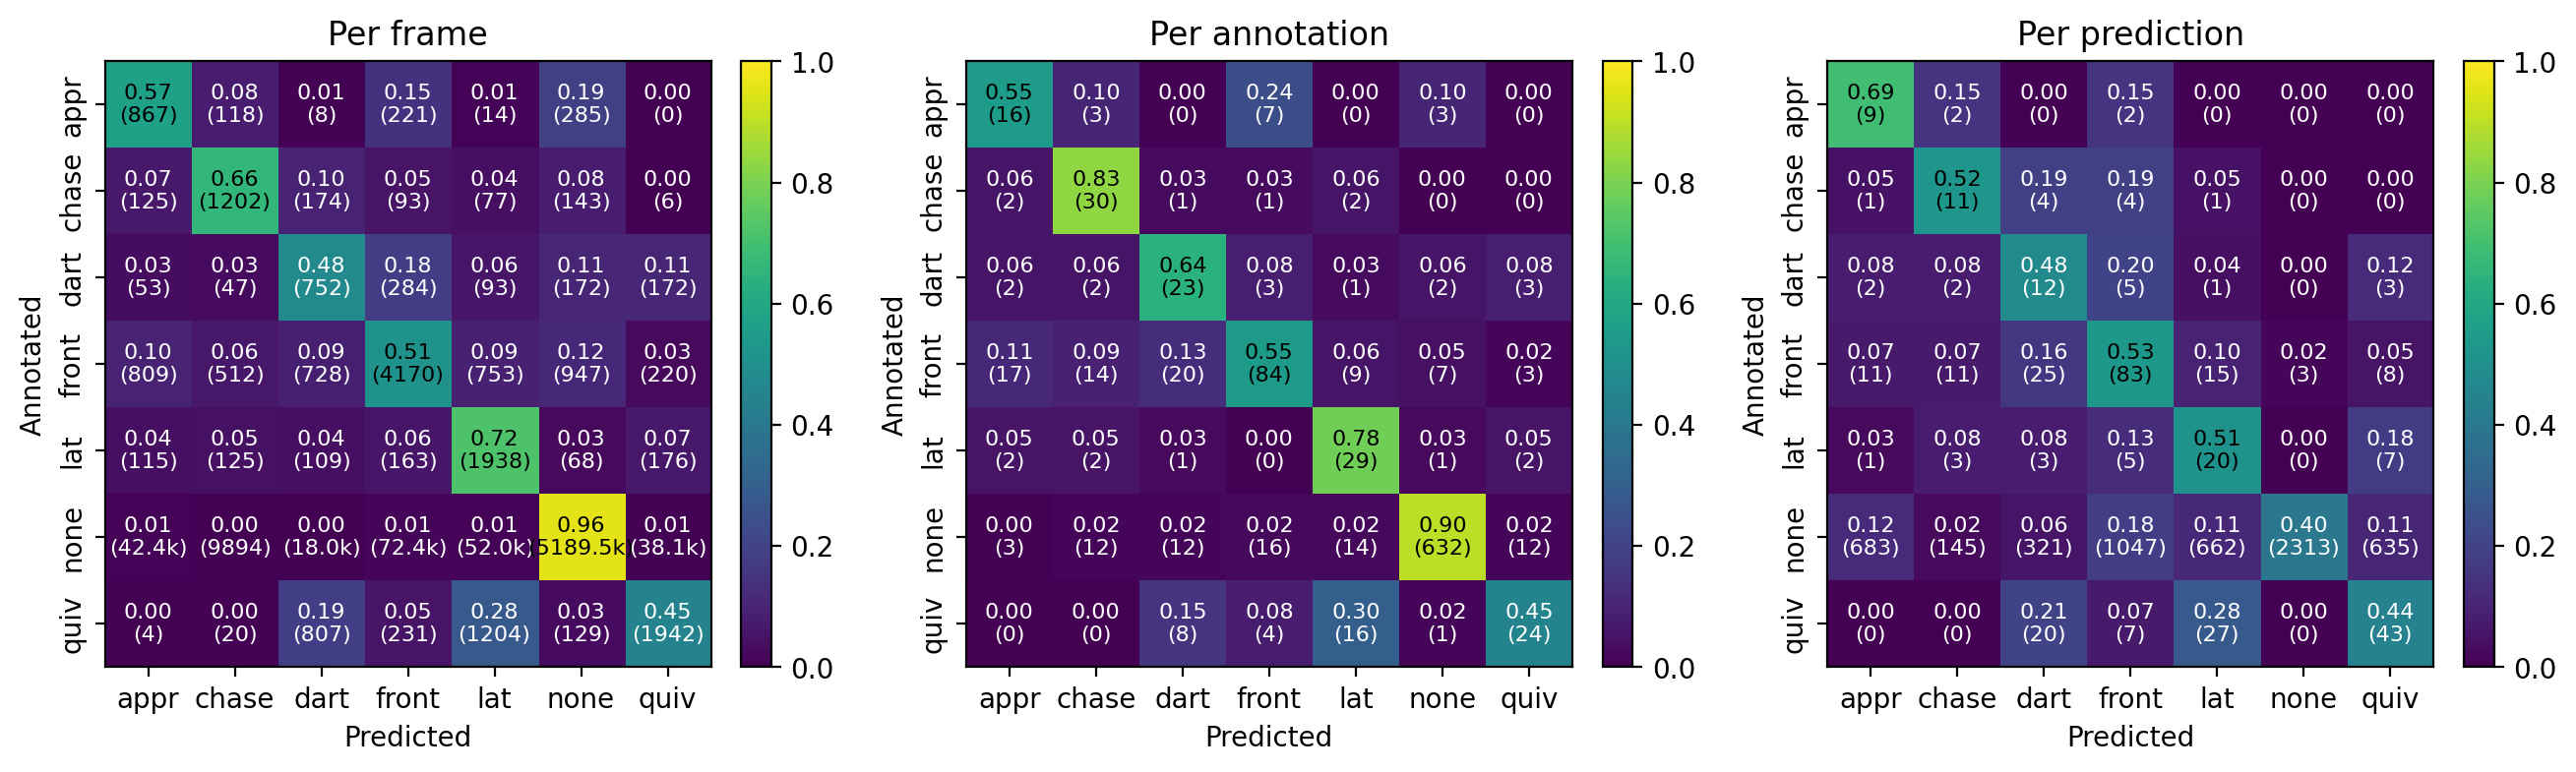

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_confusion_matrix(
    test_result.y_true_numeric,
    test_result.y_pred_numeric,
    ax=axes[0],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.annotations["category"].to_numpy()),
    dataset_train.encode(test_result.annotations["predicted_category"].to_numpy()),
    ax=axes[1],
    category_labels=category_labels,
)

plot_confusion_matrix(
    dataset_train.encode(test_result.predictions["true_category"].to_numpy()),
    dataset_train.encode(test_result.predictions["category"].to_numpy()),
    ax=axes[2],
    category_labels=category_labels,
)

axes[0].set_title("Per frame")
axes[1].set_title("Per annotation")
axes[2].set_title("Per prediction")

plt.show()

In [20]:
# save the classification result as a dataset
save_dataset(
    test_result.to_dataset(),
    directory="datasets/social_cichlids/pred",
    dataset_name="cichlids_pred",
    observation_type="predictions",
)

iterations:   0%|          | 0/2 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/9 [00:00<?, ?it/s]

scoring combinations:   0%|          | 0/9 [00:00<?, ?it/s]

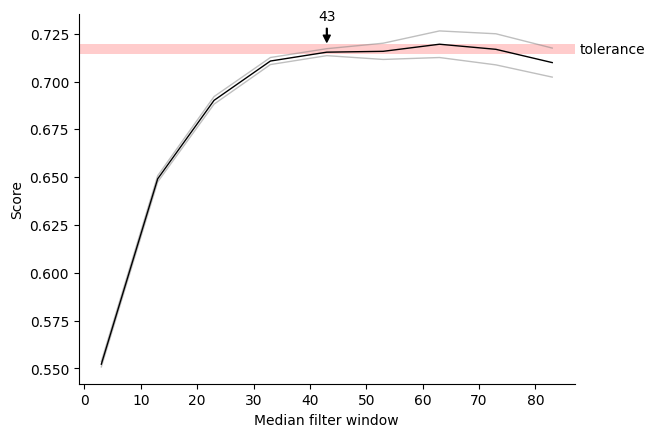

{'median_filter_window': 43.0}

In [10]:
best_parameters = optimize_smoothing(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000),
    lambda probabilities, parameters: medfilt(probabilities, parameters["median_filter_window"]),
    smoothing_parameters_grid={"median_filter_window": np.arange(3, 91, 2)},
    num_iterations=20,
    show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    show_k_fold_progress=False,
    tolerance=0.005,
    random_state=ensure_generator(1),
)

best_parameters  # 47

iterations:   0%|          | 0/20 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

thresholding categories:   0%|          | 0/4 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

scoring thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

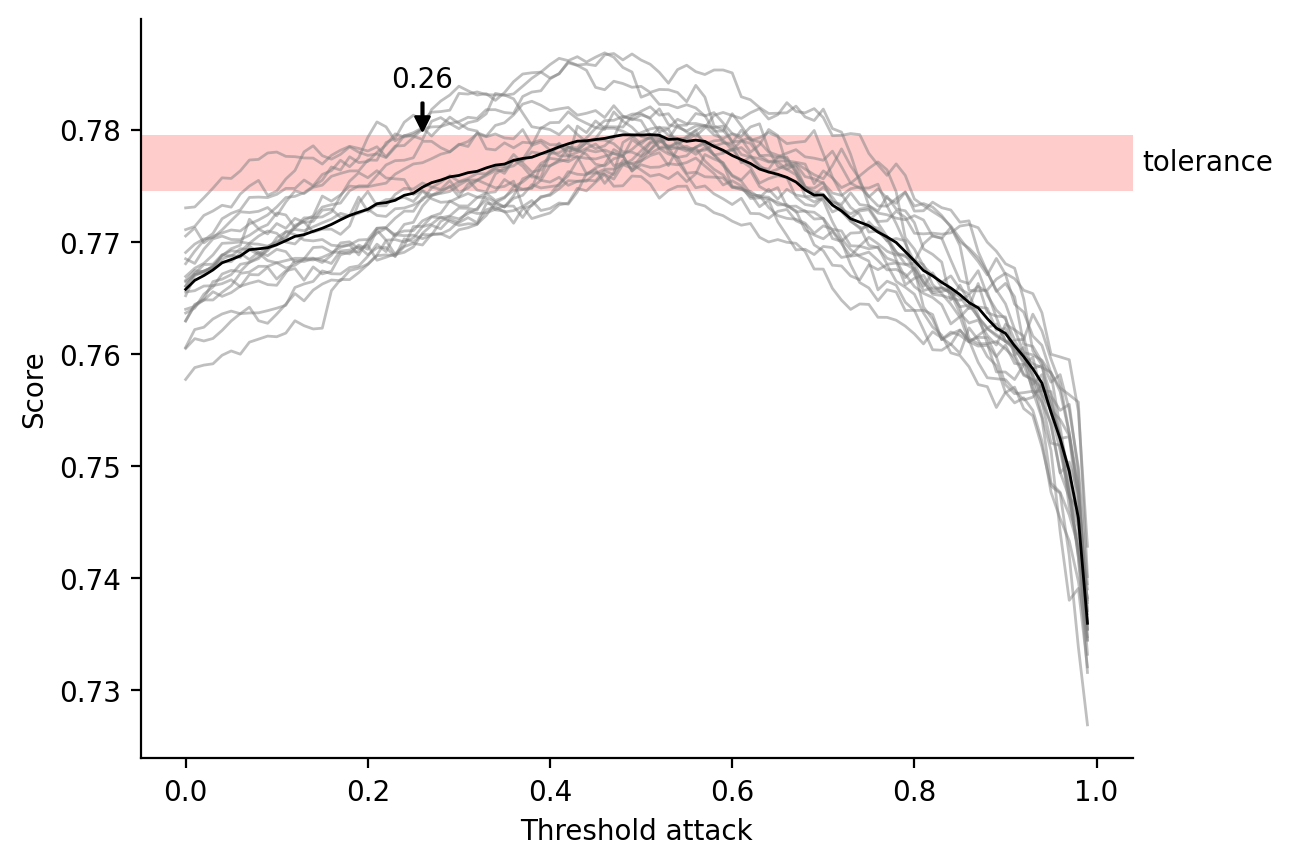

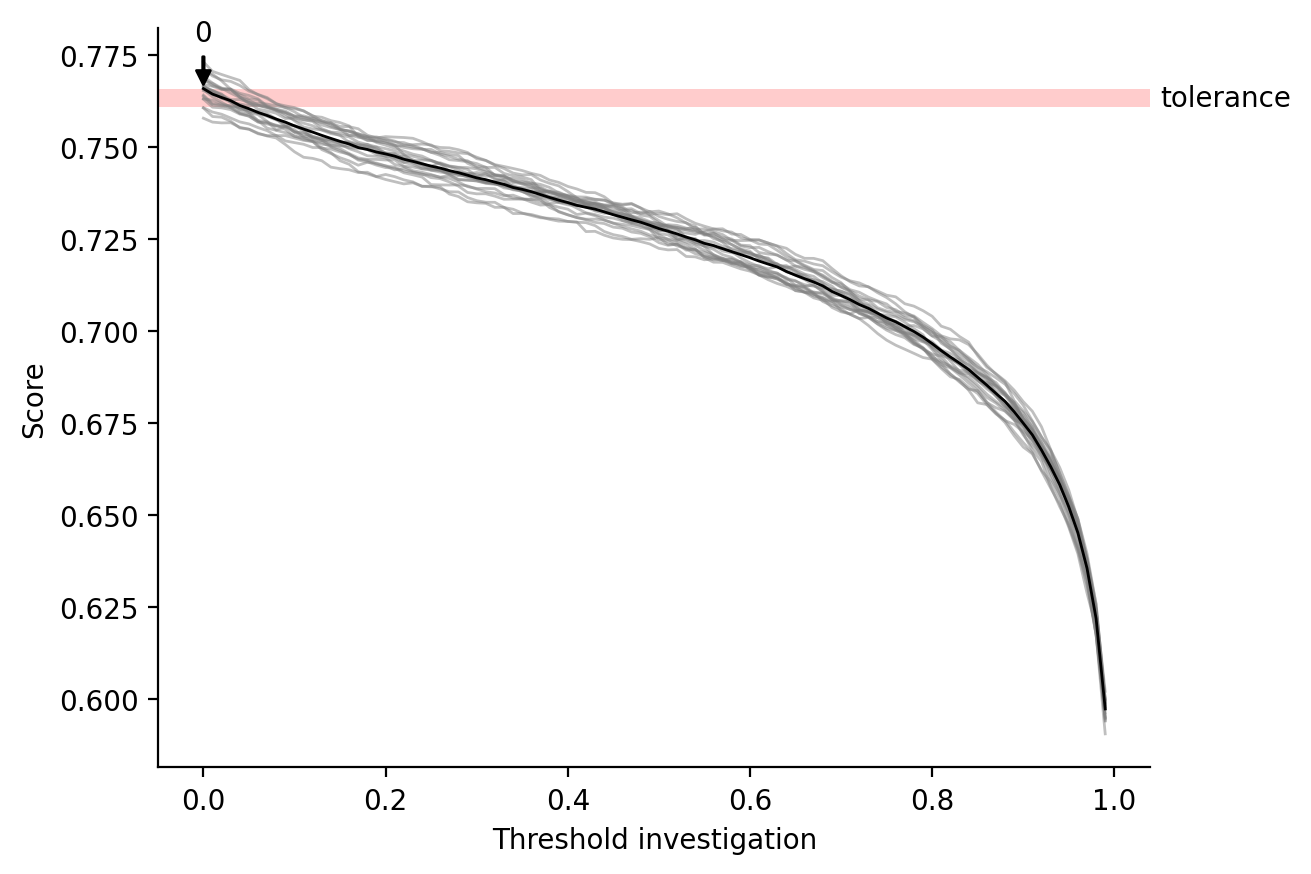

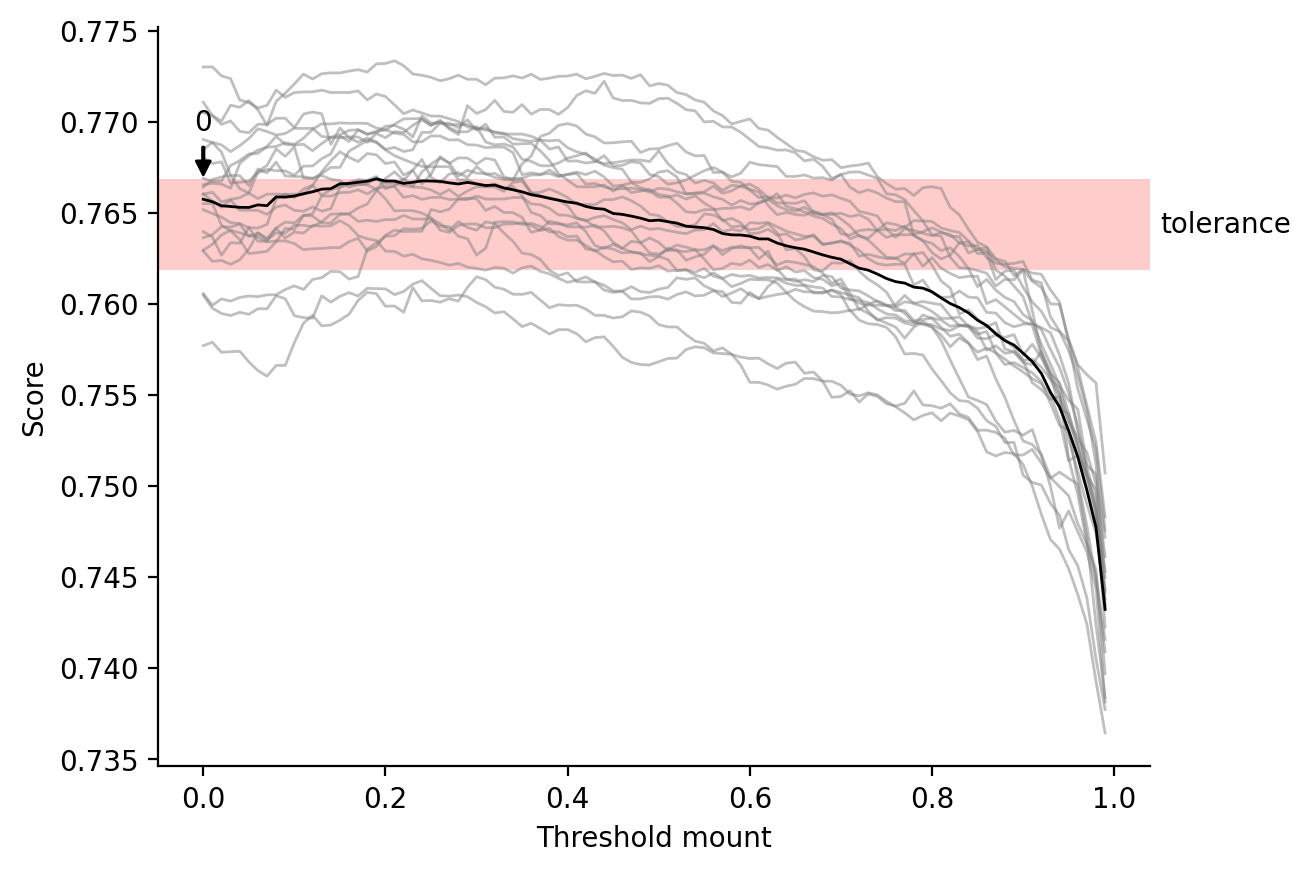

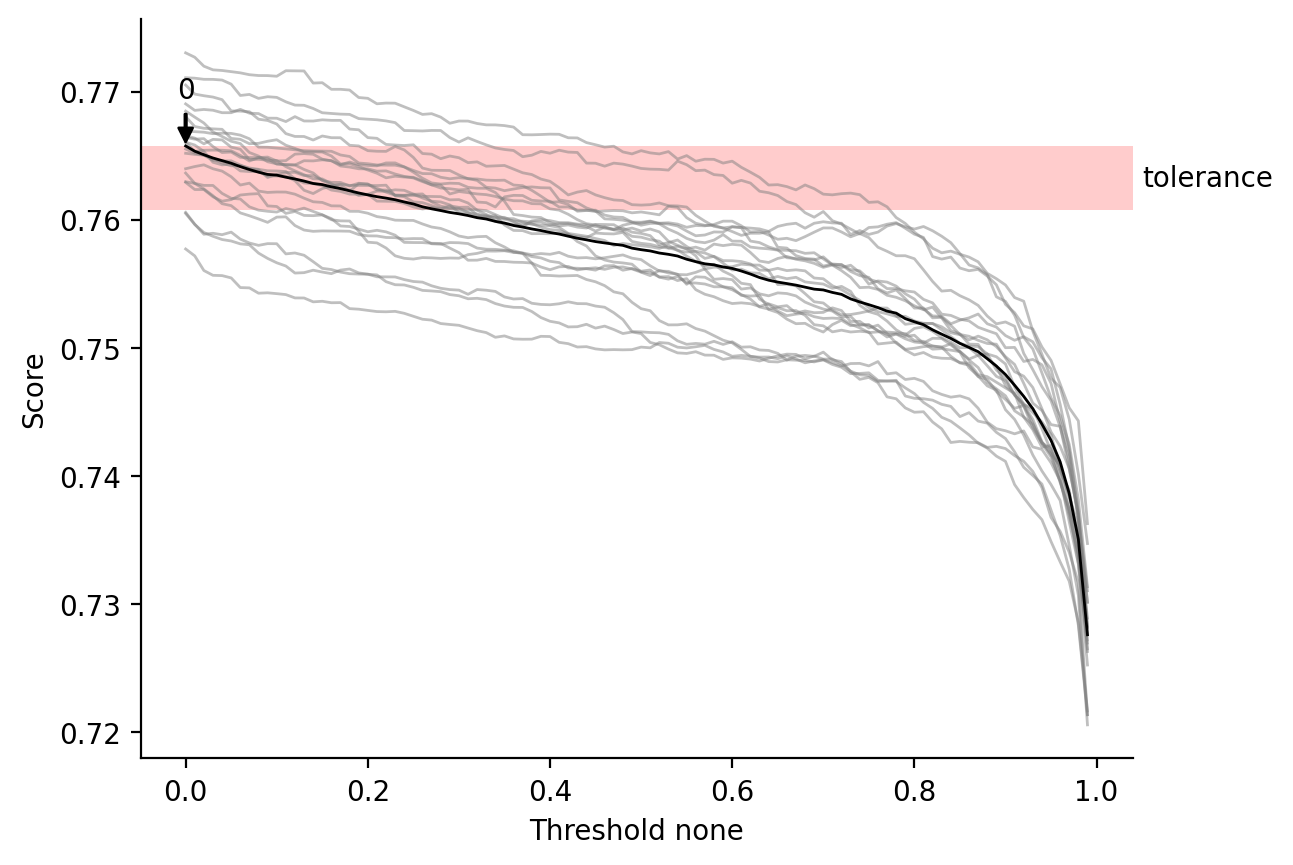

({'threshold_attack': 0.26},
 {'threshold_investigation': 0.0},
 {'threshold_mount': 0.0},
 {'threshold_none': 0.0})

In [7]:
best_thresholds = optimize_decision_thresholds(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000),
    smoothing_func=lambda probabilities: medfilt(probabilities, int(best_parameters["median_filter_window"])),
    num_iterations=20,
    show_progress=True,
    k=5,
    exclude=[("intruder", "resident")],
    sampling_func=subsample_train,
    show_k_fold_progress=False,
    decision_threshold_range=(0.0, 1.0),
    decision_threshold_step=0.01,
    tolerance=0.005,
    plot_results=True,
    random_state=ensure_generator(1),
)

best_thresholds

In [11]:
k_fold_result = k_fold_predict(
    dataset_train,
    extractor,
    XGBClassifier(n_estimators=1000, verbosity=1),
    k=5,
    exclude=[("intruder", "resident")],
    random_state=ensure_generator(1),
    sampling_func=subsample_train,
    show_progress=True,
)

k-fold predict:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
k_fold_result.classification_results.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [13]:
# category_labels = ['att', 'inv', 'mnt', 'none']

In [14]:
# 16 seems systematically shifted, maybe 41,

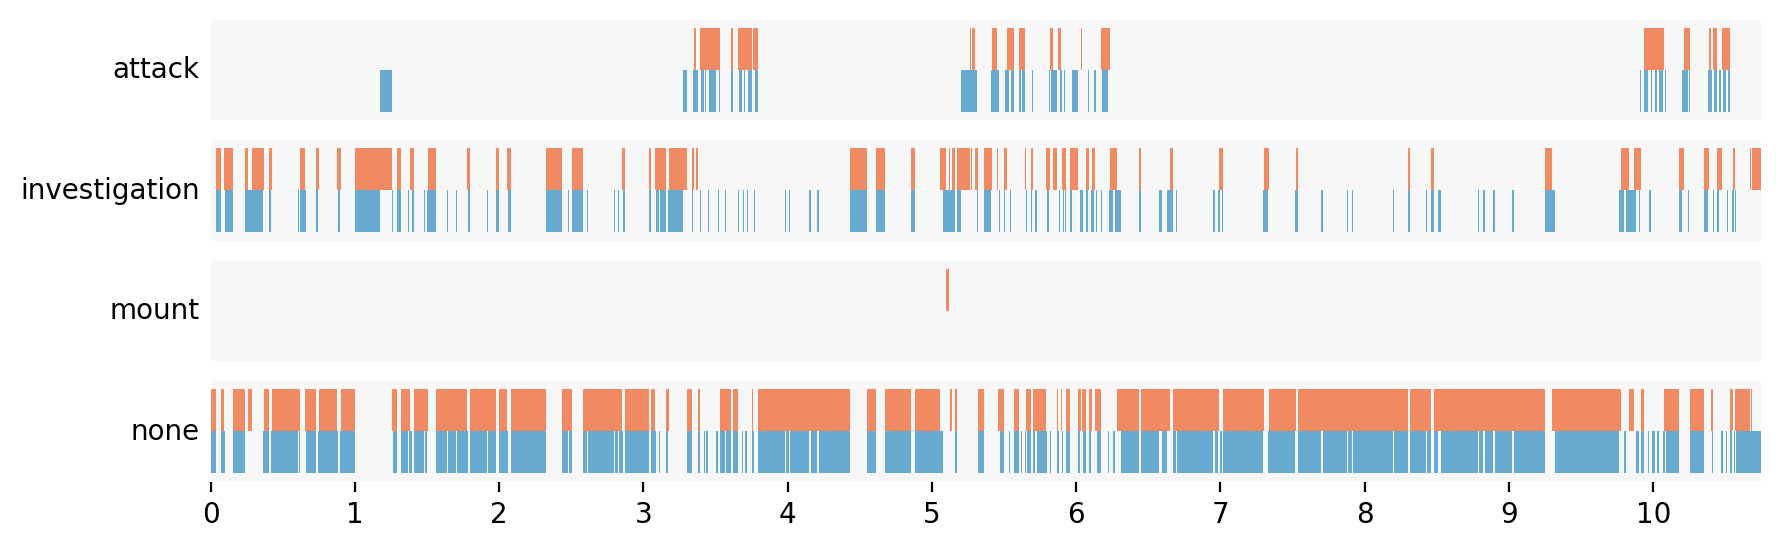

In [52]:
classification_results = k_fold_result.classification_results[1].classification_results[('resident', 'intruder')]

plot_classification_timeline(
    classification_results.predictions,
    classification_results.categories,
    annotations=classification_results.annotations,
    timestamps=classification_results.timestamps,
    interval=(-np.inf, np.inf),
    # y_proba=classification_results.y_proba,
    # y_proba_smoothed=classification_results.y_proba_smoothed,
    x_tick_step=(60 * 30),
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
)

In [53]:
# f1_timestamp_raw = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
# f1_annotation_raw = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
# f1_prediction_raw = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

# k_fold_result = k_fold_result.smooth([lambda probabilities: medfilt(probabilities, 47)])

# f1_timestamp_smooth = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
# f1_annotation_smooth = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
# f1_prediction_smooth = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

# k_fold_result = k_fold_result.threshold([0.5, 0, 0, 0])

# f1_timestamp_thresh = k_fold_result.f1_score("timestamp", encode_func=dataset_train.encode)
# f1_annotation_thresh = k_fold_result.f1_score("annotation", encode_func=dataset_train.encode)
# f1_prediction_thresh = k_fold_result.f1_score("prediction", encode_func=dataset_train.encode)

In [54]:
# plt.plot(np.arange(4), f1_timestamp_raw, "_")
# plt.plot(np.arange(4) + 0.25, f1_timestamp_smooth, "_")
# plt.plot(np.arange(4) + 0.5, f1_timestamp_thresh, "_")

In [55]:
# plt.plot(np.arange(4), f1_annotation_raw, "_")
# plt.plot(np.arange(4) + 0.25, f1_annotation_smooth, "_")
# plt.plot(np.arange(4) + 0.5, f1_annotation_thresh, "_")

In [56]:
# plt.plot(np.arange(4), f1_prediction_raw, "_")
# plt.plot(np.arange(4) + 0.25, f1_prediction_smooth, "_")
# plt.plot(np.arange(4) + 0.5, f1_prediction_thresh, "_")